In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 1s 7us/step


In [3]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
2623,28385,1106112
2856,35061,144701
2732,31479,20592
693,2696,5869
438,1365,188471


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
print(papers.sample(5).T)

                      2537             745         760   \
paper_id              1237            19621     1152975   
term_0                   0                0           0   
term_1                   0                0           0   
term_2                   0                0           0   
term_3                   0                0           0   
...                    ...              ...         ...   
term_1429                0                0           0   
term_1430                0                0           0   
term_1431                0                0           0   
term_1432                0                0           0   
subject    Neural_Networks  Neural_Networks  Case_Based   

                            1478             1949  
paper_id                 1114222            60560  
term_0                         0                0  
term_1                         0                0  
term_2                         0                0  
term_3                         

In [7]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [10]:

colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])

<Figure size 720x720 with 0 Axes>

In [14]:
len(colors),len(cora_graph),len(subjects)

(2708, 1668, 1668)

In [15]:
2078-1668

410

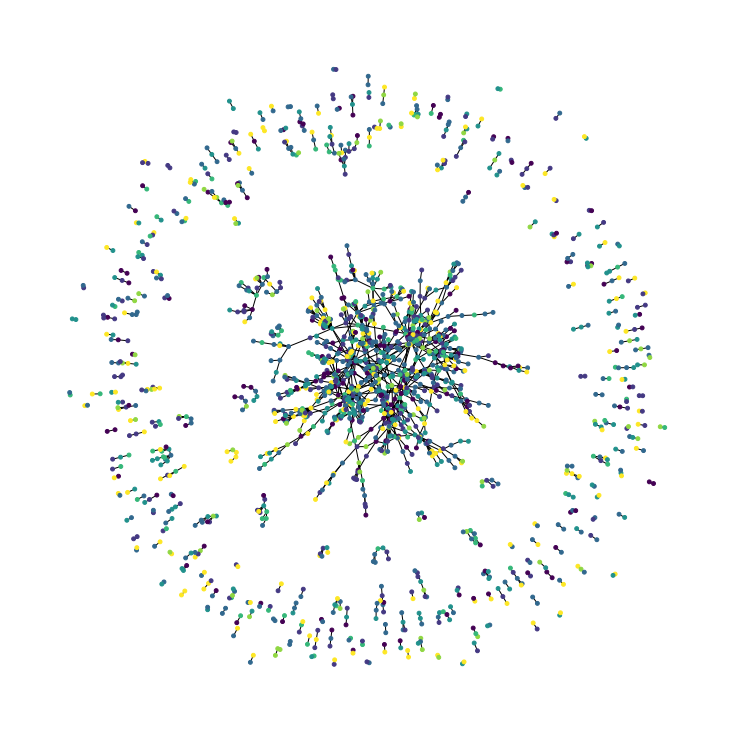

In [12]:
plt.figure(figsize=(10, 10))
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [16]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1392, 1435)
Test data shape: (1316, 1435)


In [17]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [18]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [19]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [20]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [21]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [22]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [23]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 86ms/step - loss: 3.7927 - acc: 0.1378 - val_loss: 1.8307 - val_acc: 0.3349
Epoch 2/300
5/5 [==============================] - 0s 21ms/step - loss: 2.8555 - acc: 0.2299 - val_loss: 1.8497 - val_acc: 0.3349
Epoch 3/300
5/5 [==============================] - 0s 24ms/step - loss: 2.4053 - acc: 0.2071 - val_loss: 1.8632 - val_acc: 0.3445
Epoch 4/300
5/5 [==============================] - 0s 21ms/step - loss: 2.1902 - acc: 0.2358 - val_loss: 1.8345 - val_acc: 0.3349
Epoch 5/300
5/5 [==============================] - 0s 29ms/step - loss: 2.0919 - acc: 0.2536 - val_loss: 1.8239 - val_acc: 0.3349
Epoch 6/300
5/5 [==============================] - 0s 30ms/step - loss: 1.9395 - acc: 0.3052 - val_loss: 1.8405 - val_acc: 0.3349
Epoch 7/300
5/5 [==============================] - 0s 30ms/step - loss: 1.9059 - acc: 0.2908 - val_loss: 1.8556 - val_acc: 0.4019
Epoch 8/300
5/5 [==============================] - 0s 30ms/step - loss: 1.7841 - acc: 0.32

5/5 [==============================] - 0s 26ms/step - loss: 0.4583 - acc: 0.8411 - val_loss: 0.7098 - val_acc: 0.7464
Epoch 64/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4782 - acc: 0.8377 - val_loss: 0.7183 - val_acc: 0.7416
Epoch 65/300
5/5 [==============================] - 0s 28ms/step - loss: 0.4605 - acc: 0.8436 - val_loss: 0.7138 - val_acc: 0.7464
Epoch 66/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4204 - acc: 0.8487 - val_loss: 0.7038 - val_acc: 0.7321
Epoch 67/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4652 - acc: 0.8360 - val_loss: 0.7125 - val_acc: 0.7464
Epoch 68/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4368 - acc: 0.8495 - val_loss: 0.7242 - val_acc: 0.7512
Epoch 69/300
5/5 [==============================] - 0s 31ms/step - loss: 0.4411 - acc: 0.8436 - val_loss: 0.6926 - val_acc: 0.7608
Epoch 70/300
5/5 [==============================] - 0s 24ms/step - loss: 0.4669 - acc: 0.8360 - 

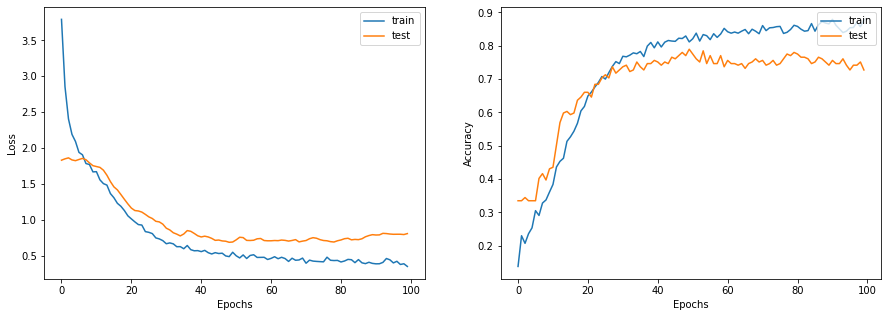

In [24]:
display_learning_curves(history)

In [25]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 77.2%


In [26]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [27]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 0.83%
- Genetic_Algorithms: 1.97%
- Neural_Networks: 20.12%
- Probabilistic_Methods: 73.66%
- Reinforcement_Learning: 0.74%
- Rule_Learning: 0.42%
- Theory: 2.27%
Instance 2:
- Case_Based: 11.11%
- Genetic_Algorithms: 8.66%
- Neural_Networks: 31.3%
- Probabilistic_Methods: 6.25%
- Reinforcement_Learning: 11.17%
- Rule_Learning: 17.22%
- Theory: 14.28%
Instance 3:
- Case_Based: 3.06%
- Genetic_Algorithms: 0.32%
- Neural_Networks: 67.59%
- Probabilistic_Methods: 22.67%
- Reinforcement_Learning: 1.44%
- Rule_Learning: 0.28%
- Theory: 4.65%
Instance 4:
- Case_Based: 5.15%
- Genetic_Algorithms: 10.15%
- Neural_Networks: 10.66%
- Probabilistic_Methods: 7.83%
- Reinforcement_Learning: 62.79%
- Rule_Learning: 1.63%
- Theory: 1.79%
Instance 5:
- Case_Based: 53.89%
- Genetic_Algorithms: 6.07%
- Neural_Networks: 13.67%
- Probabilistic_Methods: 13.03%
- Reinforcement_Learning: 0.39%
- Rule_Learning: 3.93%
- Theory: 9.02%
Instance 6:
- Case_Based: 11.57%
- Genetic_Algorith

In [28]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [29]:

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [30]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [41]:
type(x_train),x_train.shape

(numpy.ndarray, (1392,))

In [43]:
x_train[0:10]

array([ 747,   74, 1664, 1728,    8, 1328,  584, 1419,  606,   18],
      dtype=int64)

In [31]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.09715549  0.07550755  0.01175382 -0.0561885  -0.03721063  0.08982682
  -0.03664137]
 [-0.01399067 -0.02790038  0.0152983  -0.06850889 -0.00948641  0.04561906
   0.11494257]
 [ 0.07906406 -0.06350525 -0.11206552 -0.00459025 -0.06184983 -0.0195076
   0.02342551]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                             

In [32]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 220ms/step - loss: 2.1615 - acc: 0.1885 - val_loss: 1.9251 - val_acc: 0.1388
Epoch 2/300
5/5 [==============================] - 1s 109ms/step - loss: 1.9652 - acc: 0.2460 - val_loss: 1.9149 - val_acc: 0.1388
Epoch 3/300
5/5 [==============================] - 1s 117ms/step - loss: 1.9073 - acc: 0.2426 - val_loss: 1.8995 - val_acc: 0.1340
Epoch 4/300
5/5 [==============================] - 1s 109ms/step - loss: 1.9018 - acc: 0.2561 - val_loss: 1.8895 - val_acc: 0.3110
Epoch 5/300
5/5 [==============================] - 1s 104ms/step - loss: 1.8760 - acc: 0.2544 - val_loss: 1.8852 - val_acc: 0.3349
Epoch 6/300
5/5 [==============================] - 1s 102ms/step - loss: 1.8584 - acc: 0.2815 - val_loss: 1.8762 - val_acc: 0.3349
Epoch 7/300
5/5 [==============================] - 1s 107ms/step - loss: 1.8330 - acc: 0.2840 - val_loss: 1.8664 - val_acc: 0.3349
Epoch 8/300
5/5 [==============================] - 1s 103ms/step - loss: 1.8085 - a

5/5 [==============================] - 1s 105ms/step - loss: 0.5650 - acc: 0.8216 - val_loss: 0.8290 - val_acc: 0.7273
Epoch 64/300
5/5 [==============================] - 1s 107ms/step - loss: 0.5320 - acc: 0.8276 - val_loss: 0.8438 - val_acc: 0.7273
Epoch 65/300
5/5 [==============================] - 1s 105ms/step - loss: 0.5251 - acc: 0.8276 - val_loss: 0.8065 - val_acc: 0.7464
Epoch 66/300
5/5 [==============================] - 1s 112ms/step - loss: 0.5627 - acc: 0.8140 - val_loss: 0.8244 - val_acc: 0.7416
Epoch 67/300
5/5 [==============================] - 1s 118ms/step - loss: 0.5796 - acc: 0.8157 - val_loss: 0.8123 - val_acc: 0.7416
Epoch 68/300
5/5 [==============================] - 1s 113ms/step - loss: 0.5889 - acc: 0.8014 - val_loss: 0.7585 - val_acc: 0.7656
Epoch 69/300
5/5 [==============================] - 1s 104ms/step - loss: 0.5717 - acc: 0.8081 - val_loss: 0.7405 - val_acc: 0.7656
Epoch 70/300
5/5 [==============================] - 1s 109ms/step - loss: 0.5495 - acc: 0

Epoch 125/300
5/5 [==============================] - 1s 99ms/step - loss: 0.4115 - acc: 0.8825 - val_loss: 0.6768 - val_acc: 0.8373
Epoch 126/300
5/5 [==============================] - 1s 114ms/step - loss: 0.4419 - acc: 0.8698 - val_loss: 0.6638 - val_acc: 0.8373
Epoch 127/300
5/5 [==============================] - 1s 105ms/step - loss: 0.4181 - acc: 0.8749 - val_loss: 0.6677 - val_acc: 0.8469
Epoch 128/300
5/5 [==============================] - 1s 99ms/step - loss: 0.3964 - acc: 0.8774 - val_loss: 0.6648 - val_acc: 0.8373
Epoch 129/300
5/5 [==============================] - 1s 103ms/step - loss: 0.4513 - acc: 0.8732 - val_loss: 0.6632 - val_acc: 0.8325
Epoch 130/300
5/5 [==============================] - 0s 98ms/step - loss: 0.3971 - acc: 0.8631 - val_loss: 0.6274 - val_acc: 0.8278
Epoch 131/300
5/5 [==============================] - 1s 109ms/step - loss: 0.4309 - acc: 0.8808 - val_loss: 0.6259 - val_acc: 0.8278
Epoch 132/300
5/5 [==============================] - 1s 124ms/step - los

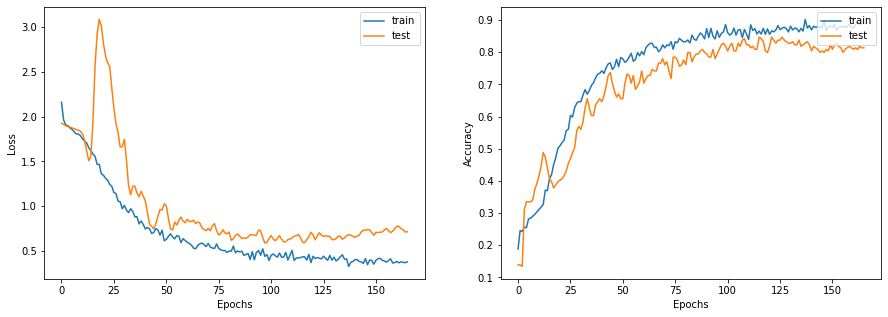

In [33]:
display_learning_curves(history)

In [34]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.29%


In [35]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [36]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 0.12%
- Genetic_Algorithms: 1.03%
- Neural_Networks: 0.73%
- Probabilistic_Methods: 96.81%
- Reinforcement_Learning: 0.14%
- Rule_Learning: 0.07%
- Theory: 1.11%
Instance 2:
- Case_Based: 0.74%
- Genetic_Algorithms: 96.12%
- Neural_Networks: 0.39%
- Probabilistic_Methods: 0.38%
- Reinforcement_Learning: 1.61%
- Rule_Learning: 0.44%
- Theory: 0.32%
Instance 3:
- Case_Based: 0.06%
- Genetic_Algorithms: 0.06%
- Neural_Networks: 96.07%
- Probabilistic_Methods: 0.88%
- Reinforcement_Learning: 0.34%
- Rule_Learning: 0.05%
- Theory: 2.54%
Instance 4:
- Case_Based: 0.32%
- Genetic_Algorithms: 2.82%
- Neural_Networks: 6.92%
- Probabilistic_Methods: 73.67%
- Reinforcement_Learning: 10.4%
- Rule_Learning: 0.31%
- Theory: 5.55%
Instance 5:
- Case_Based: 14.21%
- Genetic_Algorithms: 10.0%
- Neural_Networks: 2.19%
- Probabilistic_Method